# Data Quality Audit – Exploratory Analysis

## Introduction

This notebook presents my solution to a data quality audit assignment
completed as part of a job application process.

The objective was to identify and document at least 8 errors, inconsistencies,
and anomalies in a multi-table sales dataset in less than 3 hours.

In this analysis, I apply exploratory data analysis and validation
techniques using Python and Pandas.

The text below is the assignment.

# 1. Data analysis assignment

Raw data usually contain multiple data issues. Your goal, as a data analyst or
engineer, is to find, discuss and ultimately resolve these issues before you start
automatically uploading them into the system. As a rule, we require clients to have a
complete sales history in 2-3 years, so checking the data in Excel is usually
impossible - we typically upload the data to temporary tables in the database or load
them as Pandas dataframes, so we can run complex and scalable analysis.


The most common types of errors we encounter are **negative margins, duplicate
sales, different purchase prices within the same stores**, and **incorrect
formatting of values**. However, we also encounter errors that you have no idea
exist, and you have to look for them creatively.

Sample sales are based on real store data and are a cutout of the annual
aggregation of 15 products that were sold at 5 stores within two different groups.

All necessary data with their specification can be found in the enclosed CSVs *zones*, *sites*, *articles* and *sales*.

Can you tell what errors do the files contain? You
can use any tool of your choice for the analysis, but bear in mind we are looking for a
solution that is scalable and automatable down the road, so Excel is probably not a
great idea. Also, we want to stress that the important aspect of the analysis is a
discussion and description of your process. We are looking for a critical thinker,
not someone who has only read some tutorials and just throws random functions on
the problem.

## Files description

### *zones.csv*
The stores are divided into groups (internally called zones), over which price
optimization then takes place. A different pricing policy may apply to the
Hypermarket than to the Supermarket. Shops in one zone must have the same
prices.

### sites.csv
Stores with the same price over one product are sorted into price groups according
to the `ZoneId` key. The shops are most often sorted by region and type of shop.

### articles.csv
List of products sold that are linked to sales data via `ArticleId`.

### sales.csv
Sales are the largest and most important table. Based on the contained data,
subsequent price optimization is performed using mathematical models. Most often,
the client stores sales in daily aggregations based on primary key: product number,
day of sale, site, cost price, and sales price. Within these aggregations, of course,
most errors occur and for the proper functioning of the mathematical model, it is
necessary to eliminate these errors. The selling price `Price` and the cost price
`CostPrice` are in this case given for 1 piece.

## Approach

My approach to this task consisted of the following steps:

1. Understanding the structure of all datasets
2. Validating data types and formats
3. Checking for missing and duplicated records
4. Performing consistency checks across tables
5. Investigating suspicious values and margins
6. Documenting each identified issue

This workflow was designed to be reproducible and scalable.

In [1]:
# Let us call the libraries for the data analysis.
import numpy as np
import os
import matplotlib.pyplot as plt
import pandas as pd 
try: 
    plt.rcParams.update({
    "text.usetex": True}) # I prefer LaTeX visualization.
except Exception:
    pass

Start by analysing the basic files.

In [2]:
# zones --- Shops in one zone must have the same prices.
zones = pd.read_csv('Data/zones.csv')

In [3]:
zones

,ZoneId,ZoneName
0,1,Hypermarket
1,2,Supermarket


In [4]:
# sites: Stores with the same price over one product are sorted into *price groups* according
# to the ZoneId key. The shops are most often sorted by region and type of shop.
sites = pd.read_csv('Data/sites.csv')

In [5]:
sites.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5 entries, 0 to 4
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   SiteId    5 non-null      int64 
 1   ZoneId    5 non-null      int64 
 2   SiteName  5 non-null      object
dtypes: int64(2), object(1)
memory usage: 252.0+ bytes


In [6]:
sites

,SiteId,ZoneId,SiteName
0,4,1,Londýnská
1,5,1,Belgická
2,6,1,Vídeňská
3,7,2,Pražská
4,8,2,Plzeňská


`SiteID` runs from 4 to 8.

In [7]:
# articles: List of products sold that are linked to sales data via ArticleId.
articles = pd.read_csv('Data/articles.csv')

In [8]:
articles.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15 entries, 0 to 14
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   ArticleId    15 non-null     int64 
 1   ArticleName  15 non-null     object
dtypes: int64(1), object(1)
memory usage: 372.0+ bytes


In [9]:
articles

,ArticleId,ArticleName
0,170295,BERLINKI 250G
1,172551,"BOŽKOV SPE.KÁVOVÝ 30%0,5L"
2,172671,GNOCCHI 40% 500G SPINACI
3,167108,GRANINI NEKT.1l HRUŠKA 50%
4,176139,"HRANOLKY B"" 1KG"""
5,170069,JACOBS PORCE CAF.LATTÉ 250G
6,174022,"JÄGERMEISTER 35% 0,7L"
7,165811,JČ SMETANA KE ŠL.33% 250ML
8,165954,LIPÁNEK UHT MLÉKO 250ML KAK
9,169281,MAGGI ASIA 118G INDIE SMAŽ.NUD


In [10]:
articles[articles["ArticleId"].duplicated()]

,ArticleId,ArticleName


Empty ==> no duplicated ArticleId.

Sales:

**Sales are the largest and most important table**. Based on the contained data,
subsequent price optimization is performed using mathematical models. Most often,
the client *stores sales in daily aggregations based on primary key*: **product number,
day of sale, site, cost price, and sales price**. Within these aggregations, of course,
most errors occur and for the proper functioning of the mathematical model, it is
necessary to eliminate these errors. The selling price "Price" and the cost price
"CostPrice" are in this case given for 1 piece.

In [11]:
sales = pd.read_csv('Data/sales.csv')

In [12]:
sales # This one is large, 17997 entries.

,ArticleId,SiteId,ZoneId,Date,Quantity,Price,CostPrice
0,170936,4,1,2019-05-09,7.0,39.0,30.15
1,171979,7,2,2019-01-18,4.0,43.5,28.11
2,200838,5,1,2019-05-16,10.0,95.0,159.49
3,176139,7,2,2018-12-21,5.0,199.0,147.97
4,172551,5,1,2019-04-11,1.0,86.7,80.76
...,...,...,...,...,...,...,...
17992,170936,6,1,2018-09-10,5.0,39.0,30.06
17993,199219,6,1,2019-01-23,4.0,89.0,77.90
17994,165811,5,1,2018-12-13,4.0,21.9,15.74
17995,167108,8,2,2019-04-01,1.0,27.9,18.62


In [13]:
sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17997 entries, 0 to 17996
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   ArticleId  17997 non-null  int64  
 1   SiteId     17997 non-null  int64  
 2   ZoneId     17997 non-null  int64  
 3   Date       17997 non-null  object 
 4   Quantity   17997 non-null  float64
 5   Price      17984 non-null  float64
 6   CostPrice  17970 non-null  float64
dtypes: float64(3), int64(3), object(1)
memory usage: 984.3+ KB


- `Date` is not in datetime formatting --> need to validate.
- `Quantity` is float/not an integer --> check numbers are not decimal (non-integer).
- missing values in `Price` and `Costprice` --> check for which products and date.

In [14]:
sales.describe()

,ArticleId,SiteId,ZoneId,Quantity,Price,CostPrice
count,17997.000000,17997.00000,17997.000000,17997.000000,17984.000000,17970.000000
mean,177390.908763,5.99211,1.394121,6.260599,81.778959,64.442784
std,12249.515240,1.45662,0.488675,8.413260,72.251808,58.840182
min,165811.000000,4.00000,1.000000,-42.000000,8.700000,5.830000
25%,170069.000000,5.00000,1.000000,2.000000,26.900000,18.580000
50%,172551.000000,6.00000,1.000000,4.000000,46.900000,30.130000
75%,176139.000000,7.00000,2.000000,9.000000,95.000000,82.480000
max,200838.000000,9.00000,2.000000,432.000000,399.000000,383.010000


- `SiteId` has a value of 9 which is not in sites.csv! ---> New store? Typo I guess.
- There are negative entries in `Quantity`.
- Some entries in `Price` and `CostPrice` (given for 1 piece) are huge, like 399 and 383 --> Outliers?.

Now that we have checked the basics, let's analyse the points above and check others.

# 1) Date

In [15]:
#Date: 17997 non-null  object wrong formatting!
parsed = pd.to_datetime(sales["Date"], errors="coerce")
parsed.isna().sum()

0

Although `Date` is not in the correct formatting, there are no mistakes in the data.

In [16]:
sales["Date"].min(), sales["Date"].max(), parsed.min(), parsed.max()

('2018-07-01',
 '2019-07-31',
 Timestamp('2018-07-01 00:00:00'),
 Timestamp('2019-07-31 00:00:00'))

In [17]:
type(sales["Date"])

pandas.core.series.Series

I think it could be useful to check periods in this analysis, so let's create a function that gives the initial and final dates for a DataFrame.

In [18]:
def period(X):
    # Convert to datetime if needed
    if not pd.api.types.is_datetime64_any_dtype(X):
        X = pd.to_datetime(X, errors="coerce")
    initial = X.min()
    final = X.max()
    duration = final - initial

    print("Start: ", initial)
    print("End:   ", final)
    print("Period:", duration)

In [19]:
period(sales["Date"])

Start:  2018-07-01 00:00:00
End:    2019-07-31 00:00:00
Period: 395 days 00:00:00


# 2) Quantity has decimals?

In [20]:
# Quantity is a float and not an integer?
# Let's check if there are non-integer entries in quantities.
non_int = sales[
    sales["Quantity"] % 1 != 0
]
non_int

,ArticleId,SiteId,ZoneId,Date,Quantity,Price,CostPrice


There are only integer entries. The problem is only the formatting.

Let's do one extra verification.

In [21]:
sales["Quantity"].apply(lambda x: x.is_integer()).value_counts()

Quantity
True    17997
Name: count, dtype: int64

17997 integer entries from 17997 data entries. It's all good!

# Missing articles and new articles

In [22]:
# Are there spaces in ArtcileId in sales?
(sales["ArticleId"].astype(str).str.contains(" ")).sum()

0

`ArticleId` feature in *sales* looks good. Let's check that all of them are also in `articles`.

In [23]:
missing = articles[~articles["ArticleId"].isin(sales["ArticleId"])]

In [24]:
missing

,ArticleId,ArticleName


In [25]:
missing2 = sales[~sales["ArticleId"].isin(articles["ArticleId"])]
missing2 #Also empty. This is good.

,ArticleId,SiteId,ZoneId,Date,Quantity,Price,CostPrice


Empty ==> All good.

# 3) missing values in Price and Costprice 

How many empty entries do we have:

In [26]:
sales["CostPrice"].isna().sum(), sales["Price"].isna().sum() 

(27, 13)

Let's analyse the NaN entries in CostPrice per row.

In [27]:
sales[sales["CostPrice"].isna()]

,ArticleId,SiteId,ZoneId,Date,Quantity,Price,CostPrice
603,171979,5,1,2019-03-12,1.0,48.6,NaN
1279,167108,5,1,2019-03-05,1.0,27.9,NaN
2601,167108,5,1,2019-03-02,1.0,27.9,NaN
2918,172671,5,1,2019-03-07,1.0,19.9,NaN
3019,172671,5,1,2019-03-11,1.0,19.9,NaN
5276,194516,5,1,2019-03-10,1.0,46.5,NaN
5693,176139,5,1,2019-03-12,1.0,197.0,NaN
6648,172551,5,1,2019-03-01,1.0,98.9,NaN
6733,171979,5,1,2019-03-06,1.0,48.6,NaN
7726,165954,5,1,2019-03-03,1.0,8.7,NaN


In [28]:
# ----- Missing prices period ----- 
data_NaN_Cost = sales[sales["CostPrice"].isna()]
period(data_NaN_Cost["Date"])

Start:  2019-03-01 00:00:00
End:    2019-03-15 00:00:00
Period: 14 days 00:00:00


This is great, it only happend for 14 days on March 2019!!! This is very specific and helps to identify the issue.

In [29]:
sales[sales["Price"].isna()]

,ArticleId,SiteId,ZoneId,Date,Quantity,Price,CostPrice
549,170069,4,1,2019-04-13,1.0,NaN,42.91
811,172671,4,1,2019-04-05,1.0,NaN,10.91
4521,167108,4,1,2019-04-15,1.0,NaN,18.62
4748,176139,4,1,2019-04-01,1.0,NaN,142.00
5043,194516,4,1,2019-04-15,1.0,NaN,27.48
7992,176139,4,1,2019-04-11,1.0,NaN,142.00
10294,172551,4,1,2019-04-09,1.0,NaN,79.16
10335,171979,4,1,2019-04-01,1.0,NaN,28.82
10367,165954,4,1,2019-04-01,1.0,NaN,5.87
10568,172671,4,1,2019-04-09,1.0,NaN,10.91


In [30]:
# Missing prices are during the time 
data_NaN_price = sales[sales["Price"].isna()]
period(data_NaN_price["Date"])

Start:  2019-04-01 00:00:00
End:    2019-04-15 00:00:00
Period: 14 days 00:00:00


Also for two weeks??? These both atributes go null or NaN during a specific period. Most likely the same data pipeline failure.

Data could be filled in for each product, only in the same `ZoneId` and `SiteId`. That means, I would take the average of those products in the same locations on the next-to 2 months and fill in with the number I get. 

# 4) SiteId = 9?

In [31]:
# SiteId = 9?? In sites that ranges from 4 to 8... It must be a mistake
sum(sales["SiteId"]== 9)

253

253 mistakes/typos. What is the percentage with respect to the data?

In [32]:
253/17997*100

1.4057898538645328

In [33]:
missing_sites = sales[~sales["SiteId"].isin(sites["SiteId"])]
missing_sites

,ArticleId,SiteId,ZoneId,Date,Quantity,Price,CostPrice
53,194516,9,2,2018-11-26,11.0,40.64,27.73
164,200838,9,2,2018-11-13,5.0,99.75,87.24
373,200838,9,2,2018-11-27,1.0,99.75,87.34
385,172551,9,2,2018-11-21,1.0,95.03,84.17
411,165811,9,2,2018-11-17,5.0,23.00,15.68
...,...,...,...,...,...,...,...
17793,171979,9,2,2018-11-16,2.0,44.73,28.96
17830,170936,9,2,2018-11-24,14.0,40.95,30.66
17841,167108,9,2,2018-11-01,2.0,26.15,19.05
17896,176139,9,2,2018-11-06,3.0,240.45,152.06


In [34]:
period(missing_sites["Date"])

Start:  2018-11-01 00:00:00
End:    2018-11-30 00:00:00
Period: 29 days 00:00:00


Also very specific!!! Only during November 2018. 

# 5) Negatives entries in `Quantity`

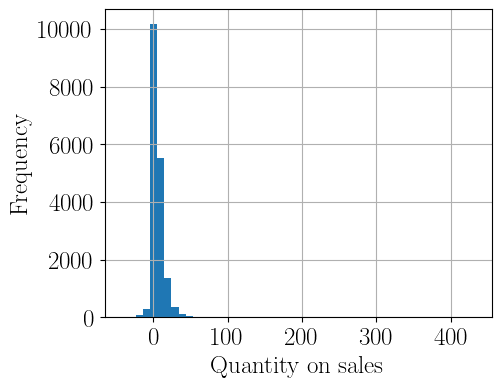

In [35]:
# Step three: Quantities. General picture:
plt.figure(figsize=(5,4))
sales["Quantity"].plot.hist(bins = 50)
fontsize = 18
plt.xlabel(r'\rm{Quantity on sales}', fontsize = fontsize)
plt.ylabel(r'\rm{Frequency}', fontsize = fontsize)
plt.grid(True)
plt.xticks(fontsize = fontsize)
plt.yticks(fontsize = fontsize)
plt.savefig('Quantity.pdf',bbox_inches='tight')

In [36]:
#How many negative or zero values do we have here?
neg = sales[sales["Quantity"] <= 0]
#neg[["ArticleId", "Date", "SiteId", "Quantity", "Price"]]
neg
#There are 820 negative or zero values. 

,ArticleId,SiteId,ZoneId,Date,Quantity,Price,CostPrice
8,176139,4,1,2019-02-17,-1.0,199.0,142.00
26,174022,5,1,2019-02-15,-16.0,239.0,196.90
34,199219,4,1,2019-02-09,-6.0,89.0,78.02
37,170295,4,1,2019-02-12,-14.0,24.5,15.78
39,174022,4,1,2019-02-04,-4.0,259.0,194.49
...,...,...,...,...,...,...,...
17852,167108,4,1,2019-02-11,-5.0,27.9,18.56
17880,165954,5,1,2019-02-12,-3.0,8.7,5.87
17971,200838,8,2,2019-02-07,-5.0,95.0,81.70
17982,200838,7,2,2019-02-08,-2.0,95.0,81.29


In [37]:
len(neg), len(neg)/17997*100 # roughly 4.6% of the data!

(820, 4.556314941379118)

In [38]:
period(neg["Date"])

Start:  2019-02-01 00:00:00
End:    2019-02-18 00:00:00
Period: 17 days 00:00:00


Also specific, only during February 2019.

In [39]:
# Outliers?
Q1 = sales["Quantity"].quantile(0.25)
Q3 = sales["Quantity"].quantile(0.75)
IQR = Q3 - Q1
lower_out = Q1 - 1.5 * IQR
upper_out = Q3 + 1.5 * IQR

In [40]:
lower_out, upper_out, IQR, sales["Quantity"].quantile(0.5) #lower_out is negative. Ignore.

(-8.5, 19.5, 7.0, 4.0)

In [41]:
outliers = sales[#sales["Quantity"] < lower_out) |
    (sales["Quantity"] > 50) #although over 19.5 it could be an outlier, let's check for a larger number
]
len(outliers)

35

In [42]:
outliers

,ArticleId,SiteId,ZoneId,Date,Quantity,Price,CostPrice
212,165811,6,1,2019-05-09,52.0,21.90,15.84
292,165811,6,1,2018-11-14,53.0,21.90,15.37
341,172551,4,1,2018-12-09,65.0,86.70,84.26
883,165811,6,1,2018-07-19,54.0,20.90,15.60
1759,165811,5,1,2018-12-22,59.0,21.90,15.74
2193,172551,5,1,2019-05-07,52.0,90.50,82.39
2313,165811,6,1,2018-08-15,54.0,20.90,15.71
2608,200838,5,1,2018-12-19,51.0,88.47,84.98
2801,200838,7,2,2018-12-20,52.0,87.90,82.99
3007,165811,7,2,2019-06-11,57.0,21.90,15.83


# 6) Huge prices in Price/CostPrice

In [43]:
# Let's check the products ordered from largest price.
price_stats = (
    sales
    .groupby("ArticleId")["Price"]
    .agg(["min", "max", "mean", "std", "count"])
    .reset_index()
)

price_stats = price_stats.merge(
    articles[["ArticleId", "ArticleName"]],
    on="ArticleId",
    how="left"
)

price_stats = price_stats[
    ["ArticleId", "ArticleName", "min", "max", "mean", "std", "count"]
]

#price_stats#.head()
price_stats_sorted = price_stats.sort_values(
    by="max",
    ascending=False
)
price_stats_sorted

,ArticleId,ArticleName,min,max,mean,std,count
10,174022,"JÄGERMEISTER 35% 0,7L",229.00,399.00,247.803420,24.391862,1801
11,176139,"HRANOLKY B"" 1KG""",183.00,295.50,205.588321,18.088087,1072
8,172551,"BOŽKOV SPE.KÁVOVÝ 30%0,5L",86.70,145.35,93.255070,8.087813,1639
14,200838,"PRAŽSKÁ VODKA 37,5%0,5L",87.90,142.50,96.861595,7.805001,1680
13,199219,"NORDIC ICE VODKA37,5%0,5L",82.50,133.50,89.672625,6.990130,1604
4,170069,JACOBS PORCE CAF.LATTÉ 250G,57.38,90.90,67.578901,12.383822,655
7,171979,POMAZÁNKA 120G VAJÍČKOVÁ,42.12,72.90,47.027201,5.165143,1011
12,194516,POMAZÁNKA CAMEMBERTOVÁ 3X120G,34.50,70.35,43.660228,5.414234,964
6,170936,ŠPENÁTOVÝ PROTLAK 400G,38.48,58.50,39.701587,3.131538,1853
2,167108,GRANINI NEKT.1l HRUŠKA 50%,24.90,41.85,28.453549,4.119585,1623


# 7) Margin

In [44]:
sales["Margin"] = sales["Price"] - sales["CostPrice"]
negative_margin = sales[sales["Margin"] < 0]

In [45]:
negative_margin

,ArticleId,SiteId,ZoneId,Date,Quantity,Price,CostPrice,Margin
2,200838,5,1,2019-05-16,10.0,95.0,159.49,-64.49
50,170936,4,1,2019-05-16,7.0,39.0,56.38,-17.38
141,172671,5,1,2019-05-15,2.0,19.9,20.55,-0.65
168,165811,6,1,2019-05-17,46.0,21.9,29.62,-7.72
181,200838,7,2,2019-05-18,6.0,95.0,152.39,-57.39
...,...,...,...,...,...,...,...,...
17769,199219,5,1,2019-05-18,9.0,89.0,146.38,-57.38
17776,167108,7,2,2019-05-16,2.0,26.9,34.82,-7.92
17814,170936,8,2,2019-05-17,11.0,39.0,56.38,-17.38
17935,174022,6,1,2019-05-13,4.0,239.0,383.01,-144.01


In [46]:
len(negative_margin), period(negative_margin["Date"])

Start:  2019-05-13 00:00:00
End:    2019-05-20 00:00:00
Period: 7 days 00:00:00


(358, None)

**358 entries with negative margin during the third week of May 2019**.

# 8) Duplicates

In [47]:
dupes = sales.duplicated(
    subset=["ArticleId", "SiteId","ZoneId", "Date"],
    keep=False
)

sales[dupes]

,ArticleId,SiteId,ZoneId,Date,Quantity,Price,CostPrice,Margin
5,167108,8,2,2019-04-10,1.0,26.9,18.62,8.28
17,176139,8,2,2019-04-09,1.0,197.0,142.00,55.00
59,167108,8,2,2019-04-15,1.0,26.9,18.62,8.28
65,176139,8,2,2019-04-16,3.0,197.0,142.00,55.00
107,170936,8,2,2019-04-02,2.0,39.0,30.13,8.87
...,...,...,...,...,...,...,...,...
17907,171979,8,2,2019-04-04,3.0,50.4,28.95,21.45
17920,170069,8,2,2019-04-27,1.0,59.9,42.37,17.53
17936,174022,8,2,2019-04-16,8.0,239.0,192.31,46.69
17977,167108,8,2,2019-04-18,3.0,26.9,18.62,8.28


**492 duplicates**.

#### Now that we covered the basics, let's cover the consistency with the different data tables.

# 9) Different purchase price within the same store

In [48]:
# Group by ArticleId, SiteId, ZoneId, Date and count unique CostPrice
price_check = (
    sales
    .groupby(["ArticleId", "SiteId", "ZoneId", "Date"])["CostPrice"]
    .nunique()
)

# Filter only cases with more than 1 CostPrice
inconsistent_cost = price_check[price_check > 1]

# Optional: show number of inconsistencies
len(inconsistent_cost)

0

In [49]:
# Merge back to see actual records
inconsistent_rows = sales.merge(
    inconsistent_cost.reset_index()[["ArticleId", "SiteId", "ZoneId", "Date"]],
    on=["ArticleId", "SiteId", "ZoneId", "Date"],
    how="inner"
)

inconsistent_rows.sort_values(["ArticleId", "SiteId", "Date"])

,ArticleId,SiteId,ZoneId,Date,Quantity,Price,CostPrice,Margin


In [50]:
price_check2 = sales.groupby(
    ["ArticleId", "SiteId", "Date"]
)["Price"].nunique()

In [51]:
price_check2.describe()

count    17751.000000
mean         0.999268
std          0.027053
min          0.000000
25%          1.000000
50%          1.000000
75%          1.000000
max          1.000000
Name: Price, dtype: float64

# 10) Zone/site price consistency

In [52]:
sales2 = sales.merge(
    sites[["SiteId", "ZoneId"]],
    on="SiteId",
    how="left"
)

In [53]:
sales2

,ArticleId,SiteId,ZoneId_x,Date,Quantity,Price,CostPrice,Margin,ZoneId_y
0,170936,4,1,2019-05-09,7.0,39.0,30.15,8.85,1.0
1,171979,7,2,2019-01-18,4.0,43.5,28.11,15.39,2.0
2,200838,5,1,2019-05-16,10.0,95.0,159.49,-64.49,1.0
3,176139,7,2,2018-12-21,5.0,199.0,147.97,51.03,2.0
4,172551,5,1,2019-04-11,1.0,86.7,80.76,5.94,1.0
...,...,...,...,...,...,...,...,...,...
17992,170936,6,1,2018-09-10,5.0,39.0,30.06,8.94,1.0
17993,199219,6,1,2019-01-23,4.0,89.0,77.90,11.10,1.0
17994,165811,5,1,2018-12-13,4.0,21.9,15.74,6.16,1.0
17995,167108,8,2,2019-04-01,1.0,27.9,18.62,9.28,2.0


In [54]:
zone_price_check = (
    sales2
    .groupby(["ArticleId", "Date", "ZoneId_x"])["Price"]
    .nunique()
)

zone_price_check[zone_price_check > 1]

ArticleId  Date        ZoneId_x
165811     2018-09-20  1           2
           2018-10-18  2           2
           2018-11-01  2           2
           2018-11-02  2           2
           2018-11-03  2           2
                                  ..
200838     2019-03-22  2           2
           2019-03-26  2           2
           2019-03-27  2           2
           2019-03-30  2           2
           2019-03-31  2           2
Name: Price, Length: 788, dtype: int64

In [55]:
zone_price_check[zone_price_check > 1]

ArticleId  Date        ZoneId_x
165811     2018-09-20  1           2
           2018-10-18  2           2
           2018-11-01  2           2
           2018-11-02  2           2
           2018-11-03  2           2
                                  ..
200838     2019-03-22  2           2
           2019-03-26  2           2
           2019-03-27  2           2
           2019-03-30  2           2
           2019-03-31  2           2
Name: Price, Length: 788, dtype: int64

**Issue #10 — Zone pricing policy violated (788 cases)**

The zone pricing rule states: *"Shops in one zone must have the same prices."*

The check above finds **788 combinations** of `(ArticleId, Date, ZoneId)` where two or more sites within the same zone recorded **different prices** for the same product on the same day. This directly violates the zone pricing contract and would corrupt any zone-level price optimisation model that assumes uniform pricing within a zone.

This is a significant data quality issue that should be investigated at the source — either by enforcing a single zone price at ingestion, or by auditing and correcting each discrepancy before model deployment.

In [56]:
price_check = (
    sales
    .groupby(["ArticleId", "SiteId", "ZoneId", "Date"])["Price"]
    .nunique()
)

# Keep only groups with more than 1 Price
inconsistent_price = price_check[price_check > 1]

# Optional: number of inconsistencies
len(inconsistent_price)

0

# SiteId consistency

In [57]:
merged = sales.merge(sites, on="SiteId", how="left")
zone_mismatch = merged["ZoneId_x"] != merged["ZoneId_y"]
zone_mismatch.sum()

253

# Time series plot

In [58]:
sales["Date"] = pd.to_datetime(sales["Date"], errors="coerce")

daily_sales = (
    sales
    .sort_values("Date")
    .groupby("Date")["Quantity"]
    .sum()
    .reset_index()
)


In [59]:
len(daily_sales["Date"])

389

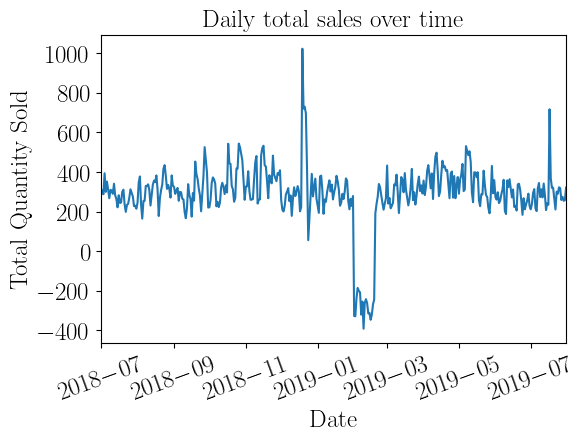

In [60]:
plt.figure(figsize=(6,4))
plt.plot(daily_sales["Date"], daily_sales["Quantity"])
plt.xlabel(r'\rm{Date}', fontsize = fontsize)
plt.ylabel(r'\rm{Total Quantity Sold}', fontsize = fontsize)
plt.title(r'\rm{Daily total sales over time}', fontsize = fontsize)
plt.xticks(fontsize = fontsize, rotation=20)
plt.yticks(fontsize = fontsize)
plt.xlim(daily_sales["Date"][0], daily_sales["Date"][388])
plt.savefig('Daily_total_sales.pdf',bbox_inches='tight')
plt.show()

In [61]:
daily_sales[daily_sales["Quantity"] == np.amax(daily_sales["Quantity"])]

,Date,Quantity
169,2018-12-19,1023.0


In the file *Data_analysis_assignment.pdf*, you may find a second section dedicated to a scripting assignment. That assignment is irrelevant for this notebook and is not going to be covered here.

# Conclusion

In this project, **9 data quality issues** were identified across the four datasets, exceeding the required minimum of 8. The findings are summarised below, grouped by their likely root cause.

---

**Root Cause 1 — Referential integrity**

- **Issue 1:** `SiteId = 9` appears in 253 sales records during November 2018, but no such site exists in `sites.csv`. Likely a typo or miscoded store identifier. Since there are only 5 stores, it is almost certainly an entry error.
- **Issue 7:** For those same 253 records, the `ZoneId` in `sales` does not match the `ZoneId` assigned to the site in `sites.csv`, placing stores in the wrong pricing group.

**Root Cause 2 — Missing values (data pipeline failures)**

- **Issue 2a:** `CostPrice` is `NaN` for 27 records at SiteId 5 (Belgická, Hypermarket) during March 1–15, 2019.
- **Issue 2b:** `Price` is `NaN` for 13 records at SiteId 4 (Londýnská, Hypermarket) during April 1–15, 2019.

Both gaps span exactly 14 days at different sites. While they could be counted as separate issues, they most likely share the same root cause: a recurring data pipeline failure that drops a price field for a fixed two-week window. Grouping them under one root cause avoids inflating the issue count.

**Root Cause 3 — Business logic violations**

- **Issue 3:** Negative margin in 358 records (~2%) during May 13–20, 2019 — `CostPrice` exceeds `Price`. Selling below cost price may indicate a data import error or exceptional pricing event.
- **Issue 4:** 492 duplicate records for SiteId 8 (Plzeňská) during April 2019, matching on `(ArticleId, SiteId, ZoneId, Date)`. These inflate sales totals and distort aggregated reporting.
- **Issue 5:** Negative `Quantity` in 820 records (~4.6%) during February 1–18, 2019. These likely represent product returns, but are indistinguishable from regular sales without an explicit flag. For demand modelling, they should be excluded or treated separately.
- **Issue 6:** 788 combinations of `(ArticleId, Date, ZoneId)` where sites in the same zone have different prices — a direct violation of the zone pricing rule *"Shops in one zone must have the same prices."*

**Root Cause 4 — Anomalies (formatting and outliers)**

- **Issue 8:** `Quantity` stored as `float64` instead of `int64`, and `Date` stored as `object` (string) instead of `datetime`. All values are valid, but these type mismatches could break downstream models or pipelines that assume correct dtypes.
- **Issue 9:** Extreme outlier quantities — e.g., 432 units of JACOBS PORCE CAF.LATTÉ 250G sold in a single day (2019-07-17), and 273 units on 2018-12-19. These are at least suspicious and warrant business validation before inclusion in any model.

---

Several of the detected issues — particularly duplicate records, negative margins, and zone pricing violations — would significantly distort demand forecasts and price optimisation if left unresolved.

Future work could focus on automating these checks into reusable, parameterised validation functions (e.g., `check_nulls_by_period(df, column, threshold)`) that can be re-run on each new data batch and integrated into the ETL pipeline.